In [1]:
import numpy as np
import h5py
import numba as nb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ebisim as eb
from fit_synth_spec import running_avg, running_std, simple_correlation_estimate_delta_ekin, bisection_fit
from fit_synth_spec import mc_fit_synth_fe_spec, fit_synth_fe_spec, _DEFAULT_INIT_GUESS, _LOWER_BOUND, _UPPER_BOUND, synth_fe_spec
from fit_synth_spec import sum_and_shrink_2d
from tqdm import tqdm
from histograms import Histogram
from _common import squeeze_array

In [2]:
histogram = Histogram.from_h5hist("./Fe_DR_045_DR2_ADC2_ADC3.h5hist")

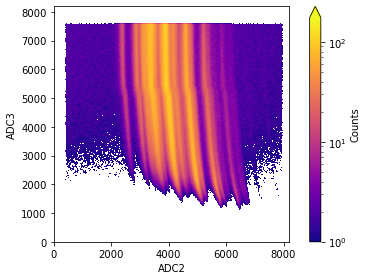

In [3]:
_ = histogram.plot()

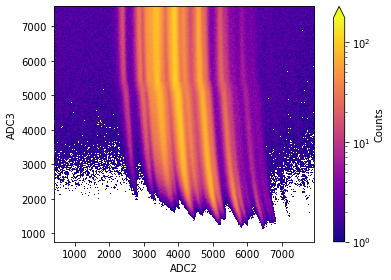

In [4]:
x_min_idx = np.argmin(np.abs(histogram.cx-395))
x_max_idx = np.argmin(np.abs(histogram.cx-7940))
y_min_idx = np.argmin(np.abs(histogram.cy-760))
y_max_idx = np.argmin(np.abs(histogram.cy-7580))
# y_max_idx = np.argmin(np.abs(histogram.cy-6378))
histogram = histogram.cropped(x_lower_idx=x_min_idx, x_upper_idx=x_max_idx, y_lower_idx=y_min_idx, y_upper_idx=y_max_idx,)
_=histogram.plot()

In [5]:
e_kin = 4400 + 800/(histogram.cx[-1]-histogram.cx[0]) * (histogram.cx-histogram.cx[0])
t = 17/(histogram.cy[-1]-histogram.cy[0]) * (histogram.cy-histogram.cy[0])


In [6]:
# nrows = 50
# strips = hist.shape[1]//nrows
# fig, ax = plt.subplots(figsize=(20,20))
# x = .5*ex[1:] + .5*ex[:-1]
# colors = plt.cm.rainbow(np.linspace(0, 1, strips))
# for k in range(strips):
#     z = strips - k
#     plt.semilogy(x, hist[:, k*nrows:(k+1)*nrows].mean(axis=-1), color=colors[k], zorder=z)
#     plt.fill_between(x, hist[:, k*nrows:(k+1)*nrows].mean(axis=-1), color="w", zorder=z)
    


In [7]:
# popt, pcov = curve_fit(
#     artif_spec,
#     e_kin,
#     data,
#     p0=(0, -80, 1, 0, 0, 0, 0, 0, 0, 0),
#     bounds=(
#         (0, -200, .01, 0, 0, 0, 0, 0, 0, 0),
#         (100, 0, 50, 1000, 1000, 1000, 1000, 1000, 1000, 1000)
#     ),
# )

In [8]:
# plt.subplots(figsize=(20, 20))
# plt.plot(e_kin, data, "k.")
# # plt.errorbar(e_kin, data, yerr=np.sqrt(data), drawstyle="steps", lw=0.5)

# plt.fill_between(e_kin, data-np.sqrt(data), data+np.sqrt(data), alpha=0.25, color="k")
# plt.plot(e_kin, artif_spec(e_kin, *popt), "r", lw=3)
# for cs in range(2, 9):
#     xs = popt[cs+1] * 1.e24 * eb.drxs_energyscan(Fe, popt[2], e_kin + popt[1])[1][-cs-1]
# #     print(xs)
#     plt.plot(e_kin, xs)
# # plt.plot(e_kin, data-artif_spec(e_kin, *popt), "-")
# # plt.ylim(1, 100)

In [9]:
# e_estim = simple_correlation_estimate_delta_ekin(e_kin, hist)
# e_varia = running_std(e_estim, 5)

# popts = []
# pstds = []

# popt = (10, -80, 1, 0, 0, 0, 0, 0, 0, 0)
# for k in tqdm(range(hist.shape[1]), desc="Fit SynSpec"):
    
#     data = hist[:, k:(k+1)].mean(axis=-1)
    
#     de0 = e_estim[k]
#     dev = e_varia[k]
    
#     if de0 < 5:
#         p0 = _DEFAULT_INIT_GUESS[:]
#         p0[1] = de0
#         p0 = np.minimum(p0, _UPPER_BOUND)
#         p0 = np.maximum(p0, _LOWER_BOUND)
#         try:
#             popt, pstd = fit_synth_fe_spec(e_kin, data, hist_err=np.sqrt(data)+1, p0=p0)
#         except RuntimeError:
#     #         popt, pstd = mc_fit_synth_fe_spec(e_kin, data, hist_err=np.sqrt(data)+1, niter=10)
#             popt, pstd = np.nan, np.nan
#     else:
#         tpopts = []
#         tpstds = []
#         for _ in range(10):
#             p0 = _DEFAULT_INIT_GUESS[:]
#             p0[1] = np.random.default_rng().normal(de0, dev, 1)
#             p0 = np.minimum(p0, _UPPER_BOUND)
#             p0 = np.maximum(p0, _LOWER_BOUND)
#             try:
#                 popt, pstd = fit_synth_fe_spec(e_kin, data, hist_err=np.sqrt(data)+1, p0=p0)
#             except RuntimeError:
#         #         popt, pstd = mc_fit_synth_fe_spec(e_kin, data, hist_err=np.sqrt(data)+1, niter=10)
#                 popt, pstd = np.nan, np.nan
#             tpopts.append(popt)
#             tpstds.append(pstd)
            
#         tpopts = np.asarray(tpopts)
#         tpsdts = np.asarray(tpstds)

#         ws = 1/(tpsdts**2)

#         popt = np.sum(tpopts * ws, axis=0)/np.sum(ws, axis=0)
#         pstd = np.sqrt(np.sum(ws*(tpopts-tpopt)**2, axis=0)/np.sum(ws, axis=0))
        
#     popts.append(popt)
#     pstds.append(pstd)
    
# popts = np.array(popts)
# pstds = np.array(pstds)
    


In [10]:
popts, pstds = bisection_fit(e_kin, histogram.counts, n=4)

100%|██████████| 1140/1140 [01:50<00:00, 10.28it/s]


In [11]:
# nr = histogram.counts.shape[1]
# idx = 1
# plt.subplots(figsize=(10,10))
# plt.errorbar(t, popts[:, idx], yerr=pstds[:, idx], fmt=".")
# # plt.ylim(np.percentile(popts[:, idx], 5), 1.5*np.percentile(popts[:, idx], 99))
# # plt.plot(t,  popts[:, idx], ".")
# # plt.fill_between(t, popts[:, idx] - pstds[:, idx], popts[:, idx] + pstds[:, idx], alpha=0.5)
# plt.ylim(-200, 100)
# # plt.ylim(0, 50)
# # plt.yscale("log")


In [12]:
# plt.subplots(figsize=(18, 18))
# # plt.plot(range(strips), popts[:, 3:])
# # plt.plot(range(strips), popts[:, 3:].sum(axis=-1))

# # plt.ylim(0, 100)
# for i in range(3, popts.shape[-1]):
# #     plt.fill_between(t, popts[:, i] - pstds[:, i], popts[:, i] +  pstds[:, i], alpha=0.3)
#     plt.plot(t, popts[:, i], ".")
# #     plt.plot(t[::11], running_avg(popts[:, i], w=5)[::11], "-")
# #     plt.errorbar(t, popts[:, i], yerr=pstds[:, i], fmt=".")
# plt.ylim(0, 1.5*np.percentile(popts[:, 4:], 95))
# # plt.ylim(0, 150)
# # plt.xlim(left=50)
# # plt.xscale("log")
# # plt.savefig("charge_breeding.pdf")

In [13]:
synth_scan = np.zeros_like(histogram.counts)
for k in range(popts.shape[0]):
    synth_scan[:, k] = synth_fe_spec(e_kin, *popts[k])

In [14]:
from copy import copy
synth_histogram = copy(histogram)
synth_histogram.counts = synth_scan

In [15]:
def fit_overview_plot(histogram, synth_histogram, popts, pstds):
    fig, axs = plt.subplots(3,2, figsize=(7, 8))

    histogram.plot(ax = axs[0, 0], vmin=0.1,vmax=histogram.counts.max(), clabel=False)
    axs[0, 0].set_title("Data")

    synth_histogram.plot(ax = axs[0, 1], vmin=0.1, vmax=histogram.counts.max(), clabel=False)
    axs[0, 1].set_title("Fit")

    # markers, caps, bars = axs[1, 0].errorbar(t, popts[:, 0], pstds[:, 0], fmt=".", ms=1, lw=1)
    # for b in bars: b.set_alpha(0.5)
    axs[1, 0].plot(t, popts[:, 0], ".")
    axs[1, 0].fill_between(t, popts[:, 0]-pstds[:, 0], popts[:, 0]+pstds[:, 0], alpha=0.5)
    axs[1, 0].set(
        ylabel="Background (a.u.)",
        xlim=(-.5, t.max()+.5),
        ylim=(0, 1.2*np.percentile(popts[:, 0], 95))
    )

    for k, lbl in zip(range(3, 10), ["He", "Li", "Be", "B", "C", "N", "O"]):
        axs[1, 1].plot(t, popts[:, k], ".", label=lbl)
        axs[1, 1].fill_between(t, popts[:, k]-pstds[:, k], popts[:, k]+pstds[:, k], alpha=0.5)
    axs[1, 1].legend(fontsize="x-small")
    axs[1, 1].set(
        ylabel="Abundance (a.u.)",
        xlim=(-.5, t.max()+.5),
        ylim=(0, 1.2*np.percentile(popts[:, 3:], 95)),
    )

    # axs[2, 0].errorbar(t, popts[:, 1], pstds[:, 1], fmt=".")
    axs[2, 0].plot(t, popts[:, 1], ".")
    axs[2, 0].fill_between(t, popts[:, 1]-pstds[:, 1], popts[:, 1]+pstds[:, 1], alpha=0.5)
    axs[2, 0].set(
        ylabel="Space charge (V)",
        xlabel="Time (s)",
        xlim=(-.5, t.max()+.5),
        ylim=(1.2*np.percentile(popts[:, 1], 5), 0),
    )

    # axs[2, 1].errorbar(t, popts[:, 2], pstds[:, 2], fmt=".")
    axs[2, 1].plot(t, popts[:, 2], ".")
    axs[2, 1].fill_between(t, popts[:, 2]-pstds[:, 2], popts[:, 2]+pstds[:, 2], alpha=0.5)
    axs[2, 1].set(
        ylabel="FWHM (eV)",
        xlabel="Time (s)",
        xlim=(-.5, t.max()+.5),
        ylim=(0, 1.2*np.percentile(popts[:, 2], 95))
    )
    plt.tight_layout()
    
    return fig

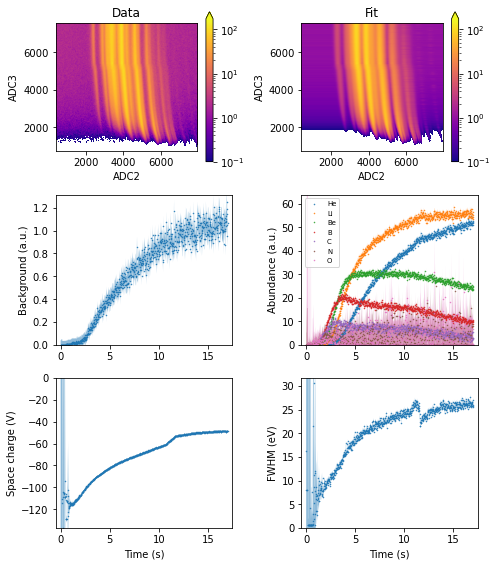

In [16]:
with plt.rc_context(rc={'lines.markersize': 1}):
    _ = fit_overview(histogram, synth_histogram, popts, pstds)
    plt.savefig("test_sheet.pdf")